Docker needs to have python3-xml and python xml libraries installed.
apt install python3-lxml


!pip3 install lxml

!pip3 install wfdb

---
Run to start fresh, i.e remove prior downloads and conversions

!rm -rf data

!ls -l data

In [1]:
import os
import re
from IPython.display import display

Define out staging directories

In [2]:
#        aMitDbDir 		: raw data goes in this directory, scraped from the web page
#        aStagingDir 	: the raw data is converted to csv & txt here
#        anHdfDir 		: where the HDF is stored
#        anHdfFilename 	: fullpath (i know...) to HDF5 file

mitdb_dir = 'data/raw_data'
stage_dir = 'data/stage_data'
hdf_dir = 'data/hdf5'
hdf_filename = 'data/hdf5/mit-bih.hdf'

dbName= 'mitdb'

In [3]:
def setup_data_directories(aRawDirectory, aStageDirectory, aDataStoreName):
    '''
    Args:
        aRawDirectory : where to store the downloaded data
        aStageDirectory : where to convert data to CSV & TXT
        aDataStoreName : where to establish the HDF5 DataStore

    Returns:
        none
    '''
    # shutil.rmtree(aRawDirectory,True)
    # shutil.rmtree(aStageDirectory,True)
    # shutil.rmtree(aDataStoreName,True)
    import errno
    def mkdir_p(path):
        try:
            os.makedirs(path)
        except OSError as exc:  # Python >2.5
            if exc.errno == errno.EEXIST and os.path.isdir(path):
                pass
            else:
                raise
    mkdir_p(aRawDirectory)
    mkdir_p(aStageDirectory)
    mkdir_p(aDataStoreName)
    
setup_data_directories(mitdb_dir,stage_dir,hdf_dir )
names = [f for f in os.listdir('data') ]
print(names)
!ls -l data

['hdf5', 'stage_data', 'raw_data']
total 12
drwxr-xr-x 2 jovyan users 4096 Feb 17 17:59 hdf5
drwxr-xr-x 2 jovyan users 4096 Feb 17 17:59 raw_data
drwxr-xr-x 2 jovyan users 4096 Feb 17 17:59 stage_data


In [4]:
def download_physionet_files(aDatabase='mghdb', aTargetDataDirectory='./data', shouldClean=False,
                             useExtensions=['atr', 'dat', 'hea']):
    
    '''
    Download MGH/MF data files from Physionet

    Args:
        aTargetDataDirectory : directory in which to store raw files
        aDatabase		: default 'mghdb'
        shouldClean		: reload the data?
        useExtensions	: different databases will have different files ['atr','dat','hea']

    Returns:
        None
    '''
    import requests
    from bs4 import BeautifulSoup
    
    extensionRegex = ''
    for ext in useExtensions:
        if len(extensionRegex) > 1:
            extensionRegex += '|'
        extensionRegex = extensionRegex + '\.' + ext

    urlPhysionetDB = 'https://www.physionet.org/physiobank/database/' + aDatabase + '/'
    htmlDB = requests.get(urlPhysionetDB).content

    # Scrape the list of all data files out of database page
    scraper = BeautifulSoup(htmlDB, "lxml")
    hrefElements = [pageElement['href'] for pageElement in scraper.find_all('a', href=True)]
    dataElements = filter(lambda pageElement: re.search(extensionRegex, pageElement, re.I), hrefElements)
    dataElements = sorted(dataElements)
    downloadURLList = [urlPhysionetDB + dataLink for dataLink in dataElements]

    targetFileList = [os.path.join(aTargetDataDirectory, fileName) for fileName in dataElements]
    i = 0
    for dataURL, localDataFile in zip(downloadURLList, targetFileList):
        i += 1
        #		if i > 10*3:
        #			break

        if os.path.isfile(localDataFile) and not shouldClean:  # don't re-download
            continue

        print('downloading from {0} to {1}'.format(dataURL, localDataFile) )
        with open(localDataFile, 'w+b') as localFileHandle:
            localFileHandle.write(requests.get(dataURL).content)
            
download_physionet_files(dbName, mitdb_dir)

downloading from https://www.physionet.org/physiobank/database/mitdb/100.atr to data/raw_data/100.atr
downloading from https://www.physionet.org/physiobank/database/mitdb/100.dat to data/raw_data/100.dat
downloading from https://www.physionet.org/physiobank/database/mitdb/100.hea to data/raw_data/100.hea
downloading from https://www.physionet.org/physiobank/database/mitdb/101.atr to data/raw_data/101.atr
downloading from https://www.physionet.org/physiobank/database/mitdb/101.dat to data/raw_data/101.dat
downloading from https://www.physionet.org/physiobank/database/mitdb/101.hea to data/raw_data/101.hea
downloading from https://www.physionet.org/physiobank/database/mitdb/102.atr to data/raw_data/102.atr
downloading from https://www.physionet.org/physiobank/database/mitdb/102.dat to data/raw_data/102.dat
downloading from https://www.physionet.org/physiobank/database/mitdb/102.hea to data/raw_data/102.hea
downloading from https://www.physionet.org/physiobank/database/mitdb/103.atr to da

In [5]:
def download_annotation_metadata():
    '''
    Args:
        None

    Returns:
        DataFrame
    '''
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    # Scrape annotation table frm MIT_-BIH info page
    annotationURL = 'https://www.physionet.org/physiobank/database/html/mitdbdir/intro.htm#annotations'
    htmlAnnotations = requests.get(annotationURL).content
    scraper = BeautifulSoup(htmlAnnotations, "lxml")
    tableElements = scraper.select('table')[-1]

    #
    metadata = pd.read_html(str(tableElements), header=0)[0]
    mask = metadata.Symbol.apply(lambda x: True)
    mask.ix[[20, 36]] = False
    metadata = metadata[mask]
    metadata['Symbol'] = metadata['Symbol'].astype(str)

    metadata.reset_index(drop=True, inplace=True)

    metadata.loc[0, 'Symbol'] = 'N'
    metadata.loc[37, 'Symbol'] = 'M'
    metadata.loc[38, 'Symbol'] = 'P'
    metadata.loc[39, 'Symbol'] = 'T'

    lut = {
        'artifact': ['artifact', 'Unclassified', 'Non-conducted', 'Fusion'],
        'arrythmia': ['flutter', 'bigeminy', 'tachycardia', 'fibrillation'],
        'other': ['bradycardia', 'Abberated', 'Premature', 'escape'],
        'signal': ['Signal quality', 'Extreme noise', 'Missed beat', 'Pause', 'Tape slippage']
    }
    def has_words(aTestString, aKeyList):
        for keyString in aKeyList:
            if not aTestString.find(keyString) == -1:
                # if keyString.lower() in aTestString.lower():
                return True
        return False
    for i in lut.keys():
        metadata[i] = metadata.Meaning.apply(lambda x: has_words(x, lut[i]))

    return metadata

annotationMetaData=download_annotation_metadata()
display(annotationMetaData) 

,Symbol,Meaning,artifact,other,arrythmia,signal
0,N,Normal beat,False,False,False,False
1,L,Left bundle branch block beat,False,False,False,False
2,R,Right bundle branch block beat,False,False,False,False
3,A,Atrial premature beat,False,False,False,False
4,a,Aberrated atrial premature beat,False,False,False,False
5,J,Nodal (junctional) premature beat,False,False,False,False
6,S,Supraventricular premature beat,False,False,False,False
7,V,Premature ventricular contraction,False,True,False,False
8,F,Fusion of ventricular and normal beat,True,False,False,False
9,[,Start of ventricular flutter/fibrillation,False,False,True,False


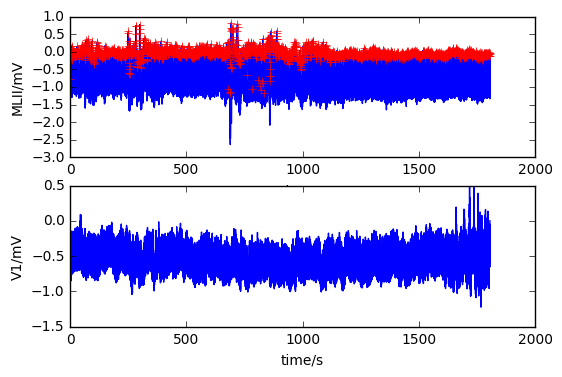

converting sample data/stage_data/mitdb.112.csv
converting annontation data/stage_data/mitdb.ann.112.txt
converting sample data/stage_data/mitdb.106.csv
converting annontation data/stage_data/mitdb.ann.106.txt
converting sample data/stage_data/mitdb.100.csv
converting annontation data/stage_data/mitdb.ann.100.txt
converting sample data/stage_data/mitdb.233.csv
converting annontation data/stage_data/mitdb.ann.233.txt
converting sample data/stage_data/mitdb.217.csv
converting annontation data/stage_data/mitdb.ann.217.txt
converting sample data/stage_data/mitdb.122.csv
converting annontation data/stage_data/mitdb.ann.122.txt
converting sample data/stage_data/mitdb.234.csv
converting annontation data/stage_data/mitdb.ann.234.txt
converting sample data/stage_data/mitdb.219.csv
converting annontation data/stage_data/mitdb.ann.219.txt
converting sample data/stage_data/mitdb.102.csv
converting annontation data/stage_data/mitdb.ann.102.txt
converting sample data/stage_data/mitdb.228.csv
convert

['mitdb.100.csv',
 'mitdb.101.csv',
 'mitdb.102.csv',
 'mitdb.103.csv',
 'mitdb.104.csv',
 'mitdb.105.csv',
 'mitdb.106.csv',
 'mitdb.107.csv',
 'mitdb.108.csv',
 'mitdb.109.csv',
 'mitdb.111.csv',
 'mitdb.112.csv',
 'mitdb.113.csv',
 'mitdb.114.csv',
 'mitdb.115.csv',
 'mitdb.116.csv',
 'mitdb.117.csv',
 'mitdb.118.csv',
 'mitdb.119.csv',
 'mitdb.121.csv',
 'mitdb.122.csv',
 'mitdb.123.csv',
 'mitdb.124.csv',
 'mitdb.200.csv',
 'mitdb.201.csv',
 'mitdb.202.csv',
 'mitdb.203.csv',
 'mitdb.205.csv',
 'mitdb.207.csv',
 'mitdb.208.csv',
 'mitdb.209.csv',
 'mitdb.210.csv',
 'mitdb.212.csv',
 'mitdb.213.csv',
 'mitdb.214.csv',
 'mitdb.215.csv',
 'mitdb.217.csv',
 'mitdb.219.csv',
 'mitdb.220.csv',
 'mitdb.221.csv',
 'mitdb.222.csv',
 'mitdb.223.csv',
 'mitdb.228.csv',
 'mitdb.230.csv',
 'mitdb.231.csv',
 'mitdb.232.csv',
 'mitdb.233.csv',
 'mitdb.234.csv',
 'mitdb.ann.100.txt',
 'mitdb.ann.101.txt',
 'mitdb.ann.102.txt',
 'mitdb.ann.103.txt',
 'mitdb.ann.104.txt',
 'mitdb.ann.105.txt',
 'mi

mitdb.100.csv


["'Elapsed time','MLII','V5'\n",
 "'hh:mm:ss.mmm','mV','mV'\n",
 "'0:00.000',-0.145,-0.065\n",
 "'0:00.003',-0.145,-0.065\n",
 "'0:00.006',-0.145,-0.065\n",
 "'0:00.008',-0.145,-0.065\n",
 "'0:00.011',-0.145,-0.065\n",
 "'0:00.014',-0.145,-0.065\n",
 "'0:00.017',-0.145,-0.065\n",
 "'0:00.019',-0.145,-0.065\n"]

In [6]:
def convert_physionet_data_to_csv(aDatabase, aSourceDirectory, aTargetDirectory, shouldClean=False):
    '''
    Convert raw data to CSV & TXT

    Args:
        aSourceDirectory :
        aTargetDirectory :

    Returns:
        None
    '''
    from subprocess import Popen, PIPE
    
    rawDataFiles = set()
    for dataFileName in os.listdir(aSourceDirectory):
        found = re.search('^(\d\d\d)\.', dataFileName)
        if found:
            rawDataFiles.add(found.group(1))

    # plot an element
    if rawDataFiles: 
        from wfdb import rdsamp, rdann
        fileName = aSourceDirectory + '/' +  next(iter(rawDataFiles))
        sig, fields=rdsamp(fileName) 
        annsamp=rdann(fileName, 'atr')[0]
        #print(sig)
        #print(sig.shape)
        #print(fields)

        from wfdb import plotwfdb
        plotwfdb(sig, fields,annsamp)


    conversionProcesses = set()
    targetSampleFile = aTargetDirectory + '/' + aDatabase + '.{name}.csv'
    # rdsamp - read WFDB signal files
    convertSamples = 'rdsamp -r ' + aSourceDirectory + '/{name} -c -v -pe > {stdout}'
    targetAnnotationFile = aTargetDirectory + '/' + aDatabase + '.ann.{name}.txt'
    # rdann - read a WFDB annotation file
    convertAnnotation = 'rdann -r ' + aSourceDirectory + '/{name} -a atr -v -e > {stdout}'

    maxOpenFiles = 6
    lowOpenFiles = 3
    numOpenFiles = 0

    # convert n files at a time, in parallel
    for rawDataFile in rawDataFiles:

        targetSample = targetSampleFile.format(name=rawDataFile)
        if not os.path.isfile(targetSample) and not shouldClean:
            print( 'converting sample {0}'.format(targetSample))
            sampleProcess = Popen(convertSamples.format(name=rawDataFile, stdout=targetSample), shell=True, stdout=PIPE)
            conversionProcesses.add(sampleProcess)
            numOpenFiles += 1

        targetAnnotation = targetAnnotationFile.format(name=rawDataFile)
        if not os.path.isfile(targetAnnotation) and not shouldClean:
            print( 'converting annontation {0}'.format(targetAnnotation))
            annotationProcess = Popen(convertAnnotation.format(name=rawDataFile, stdout=targetAnnotation), shell=True,
                                      stdout=PIPE)
            conversionProcesses.add(annotationProcess)
            numOpenFiles += 1
            

        if numOpenFiles > maxOpenFiles:
            #print('Reached max processes {0} pending'.format(numOpenFiles))
            for conversionProcess in conversionProcesses:
                numOpenFiles -= 1
                if numOpenFiles == lowOpenFiles:
                    break
                conversionProcess.communicate()
            conversionProcesses.clear()
            numOpenFiles = 0

    # ensure all files have converted
    for conversionProcess in conversionProcesses:
        conversionProcess.communicate()

convert_physionet_data_to_csv(dbName, mitdb_dir, stage_dir)        
names = sorted([f for f in os.listdir(stage_dir) ] )
display(names)
if len(names) > 0:
  with open(stage_dir + "/" + names[0]) as myfile:
    firstNlines=myfile.readlines()[0:10] #put here the interval you want
    print(names[0])
    display(firstNlines)


In [7]:
def build_hdf5_data_store(aSourceDataDirectory, aTargetHDF5,annotationMetadata):
    '''
    writes all mitdb source directory csvs and txt annotations to a single hdf5 file

    Args:
        aSourceDataDirectory: full path of directory containing mitdb csvs and txt annotations
        aTargetHDF5: fullpath of target file

    Returns:
        None
    '''
    import pandas as pd

    allRawDataFiles = os.listdir(aSourceDataDirectory)

    sampleFiles = filter(lambda x: True if re.search('csv$', x) else False, allRawDataFiles)
    sampleFiles = [os.path.join(aSourceDataDirectory, f) for f in sampleFiles]
    sampleFiles = sorted(sampleFiles)

    sampleSetNames = [re.search('(\d\d\d)', f).group(1) for f in sampleFiles]

    annotationFiles = filter(lambda x: True if re.search('ann', x) else False, allRawDataFiles)
    annotationFiles = [os.path.join(aSourceDataDirectory, f) for f in annotationFiles]
    annotationFiles = sorted(annotationFiles)

    #annotationMetadata = download_annotation_metadata()
    annotationMetadata.to_hdf(aTargetHDF5, 'Annotation_Metadata')

    def record_needs_update(aRecordName, aSampleFile, anAnnotationFile, aTargetHDF5):
        '''
        use an import data frame to keep track of the timestamps on the source files,
        Args:
        Returns:
            None
        '''
        import time
        checksum = '[{0}{1}]'.format(time.ctime(os.path.getmtime(aSampleFile)),
                                     time.ctime(os.path.getmtime(anAnnotationFile)))
        try:
            try:
                record = pd.read_hdf(aTargetHDF5, 'Import_checksums')
            except KeyError as e:
                record = pd.DataFrame({'record_name': aRecordName, 'checksum': checksum}, index=[0])
                pass
            else:
                checksum_ = record[record['record_name'] == aRecordName].checksum.tolist()[0]
                if checksum == checksum_:
                    return False

        except IndexError:
            record = record.append({'record_name': aRecordName, 'checksum': checksum}, ignore_index=True)
        else:
            record.ix[record.record_name == aRecordName, 'checksum'] = checksum

        record.to_hdf(aTargetHDF5, 'Import_checksums')
        return True
    def import_samples_and_annotations(aSampleCsvFile, anAnnotationTxtFile, aMetadataSet):
        from datetime import datetime
        
        def import_sample_data(aSampleFile):
            '''
            Args:
                aSampleFile :  CSV PHYSIONET data

            Returns:
                Pandas data frame
            '''

            dataframe = pd.read_csv(aSampleFile, skiprows=2)  # , encoding='utf-16', header=None)
            dataframe.columns = ['Elapsed_Microseconds', 'MLII_milliVolts', 'V5_milliVolts']
            dataframe.reset_index(drop=True, inplace=True)
            dataframe = dataframe.ix[1:]  # or, skip above
            dataframe.reset_index(drop=True, inplace=True)

            # Set data types
            dataframe.MLII_milliVolts = dataframe.MLII_milliVolts.astype(float)
            dataframe.V5_milliVolts = dataframe.V5_milliVolts.astype(float)

            # Change the time to a zero base and apply as the index of the data frame
            baseTime = datetime.strptime('00:00.00', '%M:%S.%f')
            dataframe.index = dataframe.Elapsed_Microseconds.apply(lambda x: datetime.strptime(x[1:-1], '%M:%S.%f') - baseTime)
            dataframe.drop('Elapsed_Microseconds', axis=1, inplace=True)

            return dataframe


        def import_annotation_data(anAnnotationFile):
            '''
            Args:
                anAnnotationFile :

            Returns:
                DataFrame
            '''
            dataframe = pd.read_table(anAnnotationFile, sep='\s\s+|\t| C')
            dataframe.columns = ['Elapsed_Microseconds', 'Sample_num', 'Type', 'Sub', 'Chan', 'Num', 'Aux']

            # Change the time to a zero base and apply as the index of the data frame
            baseTime = datetime.strptime('00:00.00', '%M:%S.%f')
            dataframe.index = dataframe.Elapsed_Microseconds.apply(lambda x: datetime.strptime(x, '%M:%S.%f') - baseTime)
            dataframe.drop('Elapsed_Microseconds', axis=1, inplace=True)

            dataframe.Sample_num = dataframe.Sample_num.astype(int)
            dataframe.Sub = dataframe.Sub.astype(int)
            dataframe.Chan = dataframe.Chan.astype(int)
            dataframe.Num = dataframe.Num.astype(int)

            return dataframe

        '''
        Args:
            aSampleCsvFile : MIT-BIH file
            anAnnotationTxtFile :

        Returns:
            Pandas data frame
        '''

        # load samples and annotations, then merge them using timestamp into a single frame
        sampleDataFrame = import_sample_data(aSampleCsvFile)
        annotationDataFrame = import_annotation_data(anAnnotationTxtFile)
        df = pd.concat([sampleDataFrame, annotationDataFrame], axis=1)

        #  Convert Type and Aux to integer values
        # Labels from MIT-BIH site
        arrythmiaSymbols = aMetadataSet[aMetadataSet.arrythmia].Symbol.tolist()
        normalSymbols = ['N', 'L', 'R']

        labels = ['arrythmia', 'normal']
        symbolSets = [arrythmiaSymbols, normalSymbols]
        annotationList = ['Type', 'Aux']

        for label, symbols in zip(labels, symbolSets):

            eventName = label + '_events'
            df[eventName] = 0

            for annotation in annotationList:
                df[eventName] = df.apply(lambda x: 1 if x[annotation] in symbols else x[eventName], axis=1)

        # add up each, just to see...
        print('calculating event occurances...')
        for label in labels:
            numEvents = len(df[df[label + '_events'] == 1].index)
            print('{0} {1} events'.format(numEvents, label))

        return df

    combinedDataFrame = None
    for sampleSet, sampleFile, annotationFile in zip(sampleSetNames, sampleFiles, annotationFiles):

        recordName = 'Record_' + sampleSet

        # skip if we've already imported this data
        if not record_needs_update(recordName, sampleFile, annotationFile, aTargetHDF5):
            continue

        print(recordName)
        combinedDataFrame = import_samples_and_annotations(sampleFile, annotationFile, annotationMetadata)
        combinedDataFrame.to_hdf(aTargetHDF5, recordName)
        
    if combinedDataFrame is not None:
        display(combinedDataFrame)

        
build_hdf5_data_store(stage_dir, hdf_filename,annotationMetaData)        



Record_100


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:95: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


calculating event occurances...
0 arrythmia events
2239 normal events


/opt/conda/lib/python3.5/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['Type', 'Aux']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Record_101
calculating event occurances...
0 arrythmia events
1860 normal events
Record_102
calculating event occurances...
0 arrythmia events
99 normal events
Record_103
calculating event occurances...
0 arrythmia events
2082 normal events
Record_104
calculating event occurances...
0 arrythmia events
163 normal events
Record_105
calculating event occurances...
0 arrythmia events
2526 normal events
Record_106
calculating event occurances...
19 arrythmia events
1507 normal events
Record_107
calculating event occurances...
0 arrythmia events
0 normal events
Record_108
calculating event occurances...
0 arrythmia events
1739 normal events
Record_109
calculating event occurances...
0 arrythmia events
2492 normal events
Record_111
calculating event occurances...
0 arrythmia events
2123 normal events
Record_112
calculating event occurances...
0 arrythmia events
2537 normal events
Record_113
calculating event occurances...
0 arrythmia events
1789 normal events
Record_114
calculating event occu

,MLII_milliVolts,V5_milliVolts,Sample_num,Type,Sub,Chan,Num,Aux,arrythmia_events,normal_events
Elapsed_Microseconds,,,,,,,,,,
00:00:00.006000,-0.080,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.008000,-0.080,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.011000,-0.080,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.014000,-0.080,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.017000,-0.080,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.019000,-0.080,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.022000,-0.075,0.135,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.025000,-0.075,0.145,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.028000,-0.090,0.155,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Show hdf5 layout

In [8]:
import pandas as pd
ecgDataframe = pd.HDFStore(hdf_filename)
display(ecgDataframe)


<class 'pandas.io.pytables.HDFStore'>
File path: data/hdf5/mit-bih.hdf
/Annotation_Metadata            frame        (shape->[40,6])     
/Import_checksums               frame        (shape->[1,2])      
/Record_100                     frame        (shape->[649998,10])
/Record_101                     frame        (shape->[649998,10])
/Record_102                     frame        (shape->[649998,10])
/Record_103                     frame        (shape->[649998,10])
/Record_104                     frame        (shape->[649998,10])
/Record_105                     frame        (shape->[649998,10])
/Record_106                     frame        (shape->[649998,10])
/Record_107                     frame        (shape->[649998,10])
/Record_108                     frame        (shape->[649998,10])
/Record_109                     frame        (shape->[649998,10])
/Record_111                     frame        (shape->[649998,10])
/Record_112                     frame        (shape->[649998,10])
/Reco

Show record that we have stored

In [9]:
ecgFilter = list(filter(lambda x: re.search('Record_', x), ecgDataframe.keys()))
if len(ecgFilter) > 0:
    display(ecgDataframe[ecgFilter[0]])


,MLII_milliVolts,V5_milliVolts,Sample_num,Type,Sub,Chan,Num,Aux,arrythmia_events,normal_events
Elapsed_Microseconds,,,,,,,,,,
00:00:00.006000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.008000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.011000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.014000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.017000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.019000,-0.145,-0.065,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.022000,-0.120,-0.080,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.025000,-0.135,-0.080,NaN,NaN,NaN,NaN,NaN,NaN,0,0
00:00:00.028000,-0.145,-0.085,NaN,NaN,NaN,NaN,NaN,NaN,0,0
